This dataset is a combination of COVID-19, Lung-Opacity, Normal, Viral Pneumonia and Tuberculosis classes.
---------------------------------------
Class Name: Number of samples : Labels
---------------------------------------
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
------------------------------
Total : 32,687
------------------------------

### Convert npz to png files

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def preprocess_and_save_images(file_path, output_dir):
    data = np.load(file_path)

    os.makedirs(output_dir, exist_ok=True)

    startIndex = 19380
    for i, (image, label) in enumerate(zip(data['image'][startIndex:], data['image_label'][startIndex:])):
        label_dir = os.path.join(output_dir, str(label[0]))
        os.makedirs(label_dir, exist_ok=True)

        filename = os.path.join(label_dir, f"{i + startIndex}.png")

        plt.imshow(image / 255.0)
        plt.axis('off')
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)  

        plt.close()  

<div style="color:red">WARNING: This loads the whole numpy array in to your memory! train.npz needs at least 32GB of RAM!</div>

Download images from here and skip this step: [https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing](https://drive.google.com/file/d/1i_SZfdp39UAIYCRz61O_OPto4ltv0HfW/view?usp=sharing)  

Or download the npz files and convert to png yourself: [https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/WNQ3GI) 

In [4]:
preprocess_and_save_images("train.npz", "images/train")

In [3]:
preprocess_and_save_images("test.npz", "images/test")

In [ ]:
preprocess_and_save_images("val.npz", "images/val")

### CLAHE

In [47]:
import cv2
import numpy as np
import os

clahe_dir = 'clahe/'
os.makedirs(clahe_dir, exist_ok=True)
clahe_train_dir = f"{clahe_dir}/train"
clahe_test_dir = f"{clahe_dir}/test"
clahe_val_dir = f"{clahe_dir}/val"
os.makedirs(clahe_train_dir, exist_ok=True)
os.makedirs(clahe_test_dir, exist_ok=True)
os.makedirs(clahe_val_dir, exist_ok=True)

In [49]:
def apply_clahe(image, brightness, clahe):
    clahe = cv2.createCLAHE(clipLimit=clahe)
    image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe_img = clahe.apply(image_bw)
    clahe_img = np.clip(clahe_img, 0, (255-brightness))
    final_img = clahe_img + brightness
    return final_img

def save_image(image, label, path, img_name):
    label_dir = os.path.join(path, str(label))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
    cv2.imwrite(os.path.join(label_dir, f'{img_name}'), image)

In [50]:
def create_clahe(dir, clahe_dir):
    for label in os.listdir(dir):
        for img_name in os.listdir(os.path.join(dir, label)):
            img_path = os.path.join(dir, label, img_name)
            image = cv2.imread(img_path) 
            clahe_image = apply_clahe(image,20,20)
            save_image(clahe_image, label, clahe_dir, img_name)


In [52]:
create_clahe("images/train", clahe_train_dir)

In [45]:
create_clahe("images/test", clahe_test_dir)

In [46]:
create_clahe("images/val", clahe_val_dir)

you can see the difference here

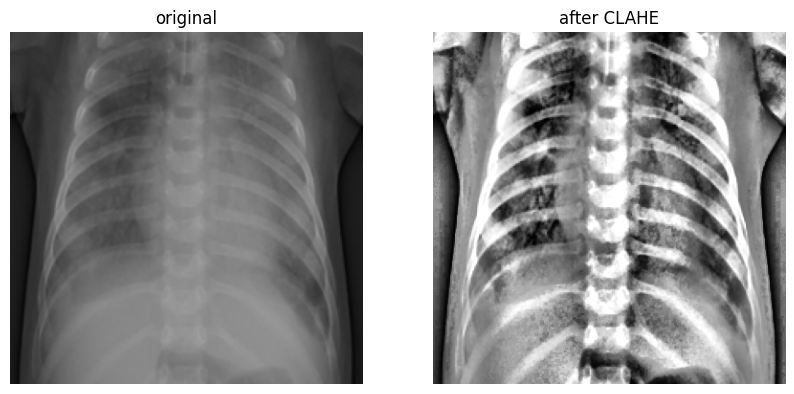

In [53]:
import random

images_train_dir = 'images/train'

random_label = random.choice(os.listdir(images_train_dir))
random_img_name = random.choice(os.listdir(os.path.join(images_train_dir, random_label)))
random_img_path = os.path.join(images_train_dir, random_label, random_img_name)
random_image = cv2.imread(random_img_path)

clahe_random_image = apply_clahe(random_image, 20, 20)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.title("original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(clahe_random_image, cmap='gray')
plt.title("after CLAHE")
plt.axis('off')

plt.show()

### Define the Dataloder for the dataset

In [54]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
import numpy as np

In [55]:
from torchvision import transforms

class XRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.img_paths = self._get_img_paths()

    def _get_img_paths(self):
        img_paths = []
        for cls_name in self.classes:
            cls_dir = os.path.join(self.root_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                img_paths.append((img_path, int(cls_name)))
        return img_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.GRAY)
        image = image.float() / 255.0

        if self.transform:
            image = self.transform(image)
        return image, label

# Define data augmentation transforms
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),       # Randomly rotate the image by up to 15 degrees
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the image
])


In [56]:
images_train_dir = 'clahe/train'
test_dir = 'clahe/test'
val_dir = 'clahe/val'

In [57]:
train_dataset = XRayDataset(images_train_dir, transform=data_transform)
test_dataset = XRayDataset(test_dir)
val_dataset = XRayDataset(val_dir)

In [58]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

### Show one example image

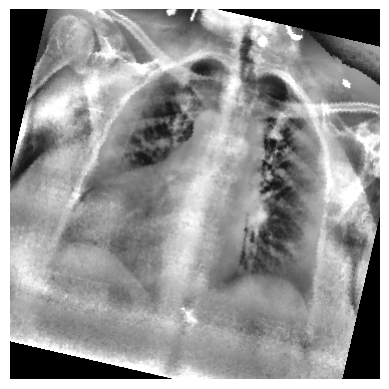

Label: tensor(4)


In [77]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

image = images[0].permute(1, 2, 0).numpy()  
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

print("Label:", labels[0])


## Define Neural Network

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### (skip this step) Setting the environment variables for amd rx6700xt  

In [61]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env HCC_AMDGPU_TARGET=gfx1032

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: HCC_AMDGPU_TARGET=gfx1032


#### Creating Device

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [63]:
num_classes = 5

#### Using own model implementation

In [64]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, num_classes=5):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 92 * 92, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Attention mechanism
        self.attention = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        attention_weights = torch.sigmoid(self.attention(x))
        attention_weights = F.interpolate(attention_weights, size=x.size()[2:], mode='nearest')
        
        x = x * attention_weights
        
        x = x.view(-1, 32 * 92 * 92)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, attention_weights


In [65]:
model = Model()
model.to(device)
variant="data_augmentation_clahe"

#### Using pretrained model - doesnt work right now!

In [140]:
import torchvision.models as models

In [141]:
model = models.resnet18(pretrained=True)
model.to(device)
model.fc = nn.Linear(model.fc.in_features, num_classes)

/Users/kon/Documents/Developer/medical-chest-xray/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kon/Documents/Developer/medical-chest-xray/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Loss Function and Optimizer Function

In [66]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [67]:
import os
from tqdm import tqdm

num_epochs = 6
starting_epoch=0 # what previous epoch to use for training, standard is 0


save_dir = "saved_models"
if starting_epoch!=0:
    model.load_state_dict(torch.load(f'{save_dir}/{variant}_epoch_{starting_epoch}.pth'))
    
os.makedirs(save_dir, exist_ok=True)

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    with tqdm(train_loader, desc=f'Epoch {epoch+1+starting_epoch}/{num_epochs+starting_epoch}', leave=False) as t:
        for i, data in enumerate(t):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            t.set_postfix(loss=running_loss / (i + 1))
            
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate training and validation accuracy
    #train_accuracy = correct / total
    val_accuracy = val_correct / val_total
    
    # Save the model at the end of each epoch
    epoch_save_path = os.path.join(save_dir, f"{variant}_epoch_{epoch+1+starting_epoch}.pth")
    torch.save(model.state_dict(), epoch_save_path)

    print(f"Variant: {variant} Epoch {epoch + 1 + starting_epoch}/{num_epochs + starting_epoch}, Average Loss: {running_loss / len(train_loader)}, Validation Accuracy: {val_accuracy}")

Variant: data_augmentation_clahe Epoch 1/6, Average Loss: 1.1407001691385739, Validation Accuracy: 0.2307927762473217


Variant: data_augmentation_clahe Epoch 2/6, Average Loss: 0.7778087800906494, Validation Accuracy: 0.2898683807774717


Variant: data_augmentation_clahe Epoch 3/6, Average Loss: 0.5980262387100285, Validation Accuracy: 0.3640955004591368


Variant: data_augmentation_clahe Epoch 4/6, Average Loss: 0.49832907298406615, Validation Accuracy: 0.27502295684113864


Variant: data_augmentation_clahe Epoch 5/6, Average Loss: 0.44652740803181057, Validation Accuracy: 0.3907254361799816


Variant: data_augmentation_clahe Epoch 6/6, Average Loss: 0.4071271890747022, Validation Accuracy: 0.32843587389041934


### Plot training loss over epochs

### Calculate Accuracy

In [68]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np

epoch=6
#model.load_state_dict(torch.load(f'saved_models/{variant}_epoch_{epoch}.pth'))
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
predicted_labels = []
true_labels = []
attention_masks = []

with torch.no_grad(), tqdm(total=len(test_loader.dataset)) as pbar:
    for i, data in enumerate(test_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs, attention = model(images) 
        
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        attention_masks.extend(attention.cpu().numpy())
        pbar.update(len(labels))
        
        # Log predictions
        #log_predictions(image path, labels(the correct answer), predicted, attention)

accuracy = 100 * correct / total
print('Accuracy of the network on the test images: %.2f %%' % accuracy)

# Convert lists to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)
attention_masks = np.array(attention_masks)

100%|██████████| 6540/6540 [00:14<00:00, 456.71it/s]


Accuracy of the network on the test images: 32.80 %


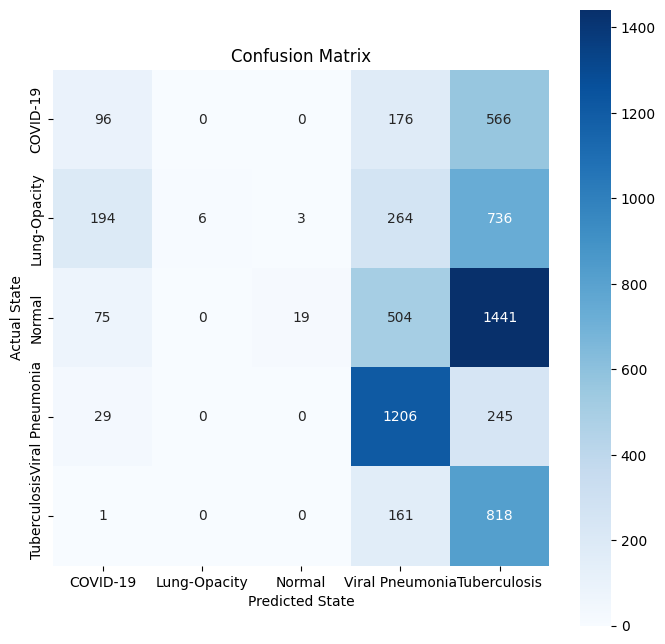

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

label_mapping = {
    0: 'COVID-19',
    1: 'Lung-Opacity',
    2: 'Normal',
    3: 'Viral Pneumonia',
    4: 'Tuberculosis'
}

images, class_labels = next(iter(train_loader))
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_sliced = conf_matrix[:5, :5]
class_labels_mapped = [label_mapping[label.item()] for label in class_labels.unique()]

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_sliced, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=class_labels_mapped, yticklabels=class_labels_mapped)
plt.xlabel('Predicted State')
plt.ylabel('Actual State')
plt.title('Confusion Matrix')
plt.show()


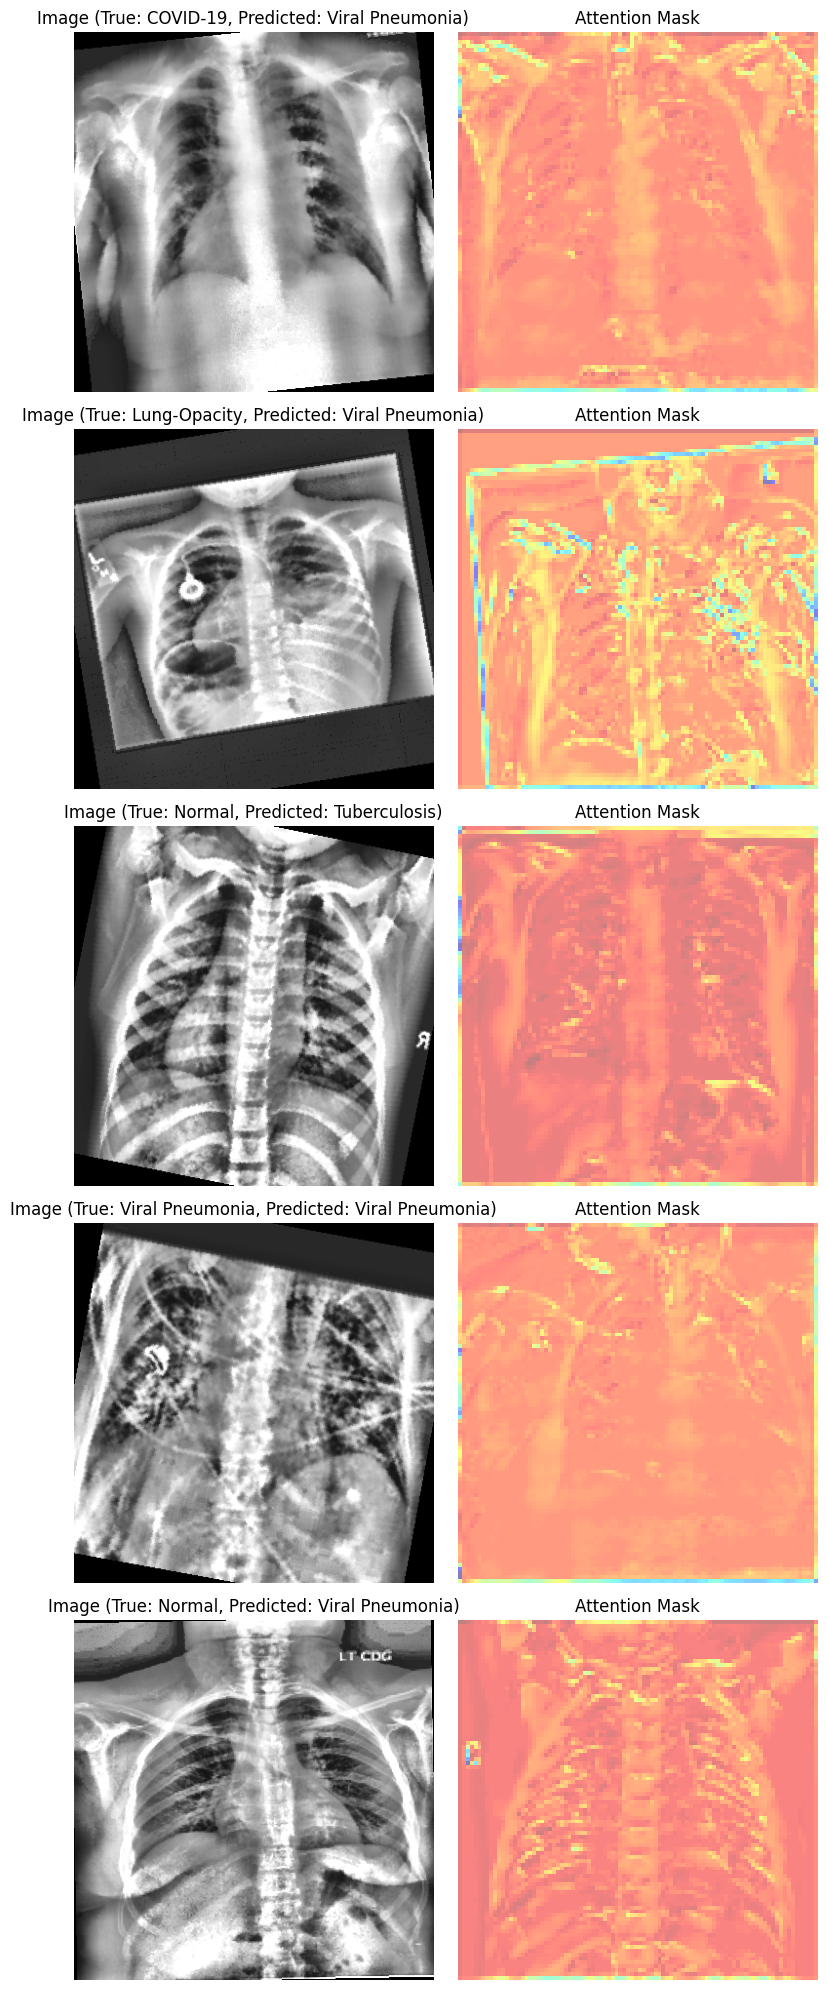

In [82]:
import matplotlib.pyplot as plt
import numpy as np

def render_predictions(images, attention_masks, true_labels, predicted_labels, label_mapping):
    num_samples = min(5, len(images)) 
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4*num_samples))
    
    for i in range(num_samples):
        image = images[i].squeeze() 
        attention_mask = attention_masks[i].squeeze()  
        
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(f'Image (True: {label_mapping[true_labels[i]]}, Predicted: {label_mapping[predicted_labels[i]]})')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(attention_mask, cmap='jet', alpha=0.5)
        axes[i, 1].set_title('Attention Mask')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

render_predictions(images, attention_masks, true_labels, predicted_labels, label_mapping)


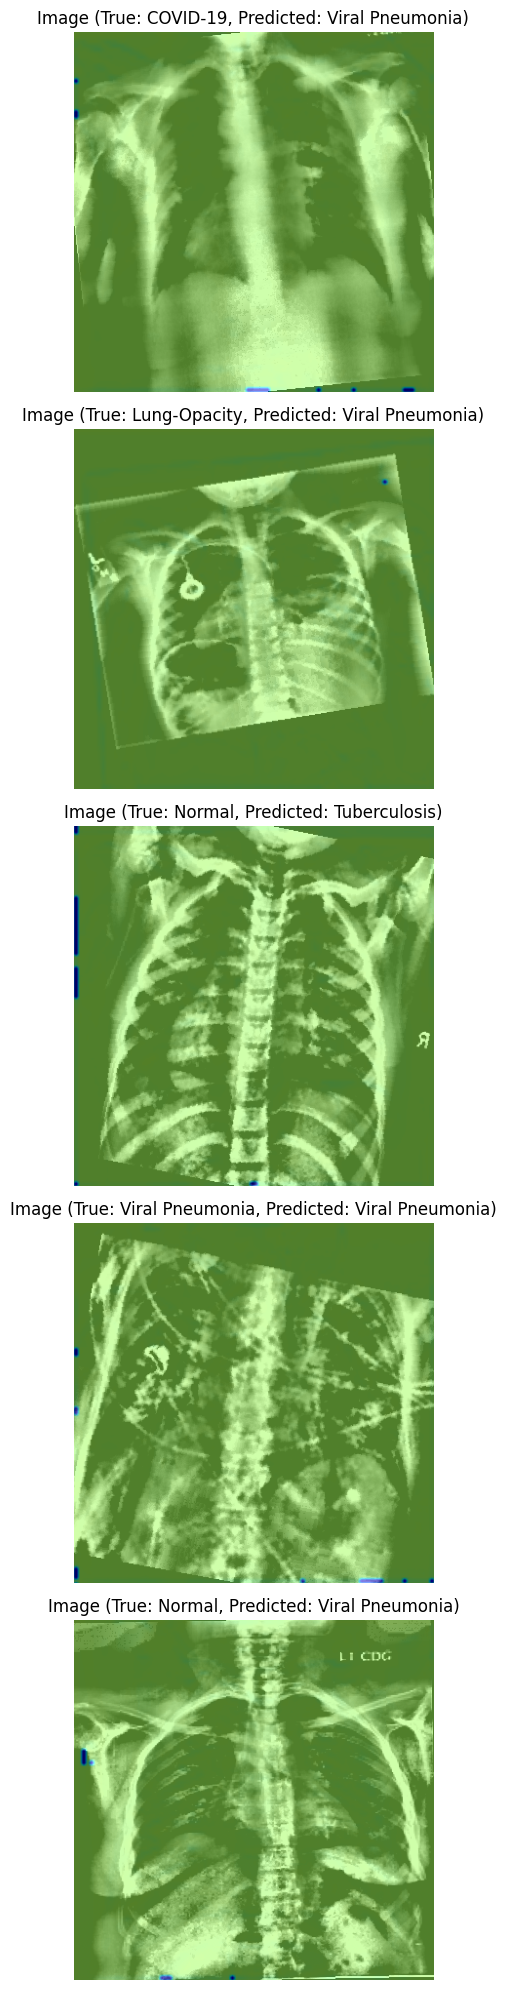

In [83]:
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import skimage

def overlay_attention(image, attention_mask, threshold=0.5, alpha=0.5, cmap='jet'):
    attention_mask_thresholded = np.where(attention_mask > threshold, attention_mask, 0)
    attention_mask_resized = resize(attention_mask_thresholded, image.shape[:2])
    
    image_rgb = plt.cm.gray(image)[:, :, :3]  # Keep only the first 3 channels
    color_map = plt.get_cmap(cmap)(attention_mask_resized)[:, :, :3]  # Keep only the first 3 channels
    blended_image = (1 - alpha) * image_rgb + alpha * color_map
    
    return blended_image


def render_predictions(images, attention_masks, true_labels, predicted_labels, label_mapping):
    num_samples = min(5, len(images)) 
    fig, axes = plt.subplots(num_samples, 1, figsize=(6, 4*num_samples))
    
    for i in range(num_samples):
        image = images[i].squeeze() 
        attention_mask = attention_masks[i].squeeze() 
        
        blended_image = overlay_attention(image, attention_mask)
        
        axes[i].imshow(blended_image)
        axes[i].set_title(f'Image (True: {label_mapping[true_labels[i]]}, Predicted: {label_mapping[predicted_labels[i]]})')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

render_predictions(images, attention_masks, true_labels, predicted_labels, label_mapping)


# AI Explainability

## Loading the model

In [84]:
import torch
import torchvision
from torchvision import models
import numpy as np

In [85]:
torch.manual_seed(123)
np.random.seed(123)

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        output, _ = self.model(x)
        return output

In [87]:
# model = Model()
# model.load_state_dict(torch.load('saved_models/no_preprocessing_epoch_6.pth'))
model.eval()

model_wrapper = ModelWrapper(model)
model_wrapper.eval()


ModelWrapper(
  (model): Model(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=270848, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=5, bias=True)
    (attention): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

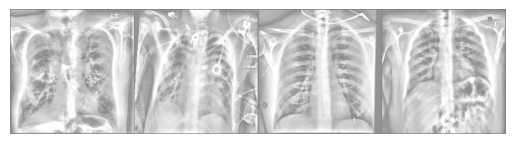

GroundTruth:  tensor(4) tensor(3) tensor(2) tensor(4)
Predicted:  tensor(4, device='cuda:0') tensor(3, device='cuda:0') tensor(4, device='cuda:0') tensor(4, device='cuda:0')


In [88]:
xai_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

dataiter = iter(xai_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(4)))

images, labels = images.to(device), labels.to(device)
outputs = model_wrapper(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % predicted[j]
                              for j in range(4)))

In [89]:
from captum.attr import Saliency, IntegratedGradients, DeepLift
from captum.attr import visualization as viz

In [90]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [91]:
def attribute_image_features(algorithm, input, **kwargs):
    model_wrapper.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [92]:
saliency = Saliency(model_wrapper)
grads = saliency.attribute(input, target=labels[ind].item())
grads = grads[0].cpu().numpy().transpose(1, 2, 0)
print(grads.shape)

(369, 369, 1)


In [93]:
ig = IntegratedGradients(model_wrapper)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = attr_ig[0].cpu().detach().numpy().transpose(1, 2, 0)
print('Approximation delta: ', abs(delta))
print(attr_ig.shape)

Approximation delta:  tensor([0.0362], device='cuda:0', dtype=torch.float64)
(369, 369, 1)


Original Image
Predicted: tensor(4, device='cuda:0')  Probability: 0.6288070678710938


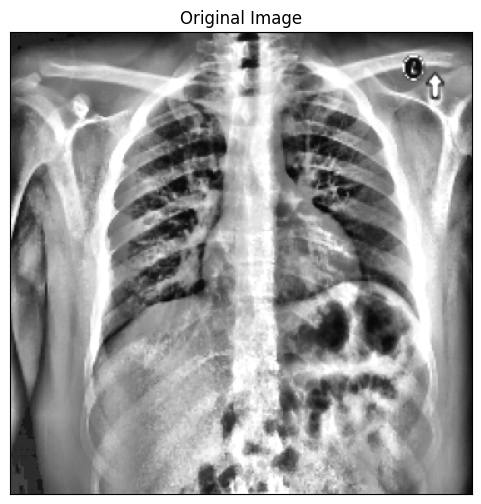

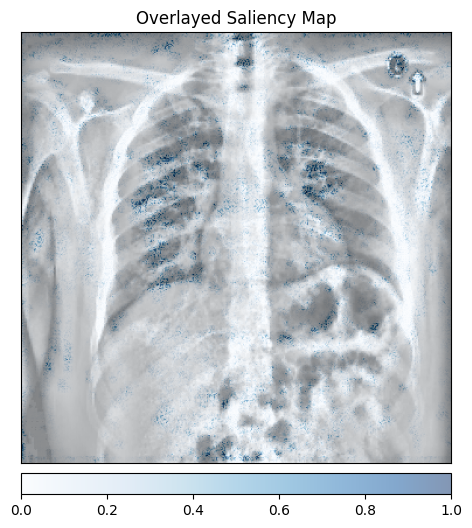

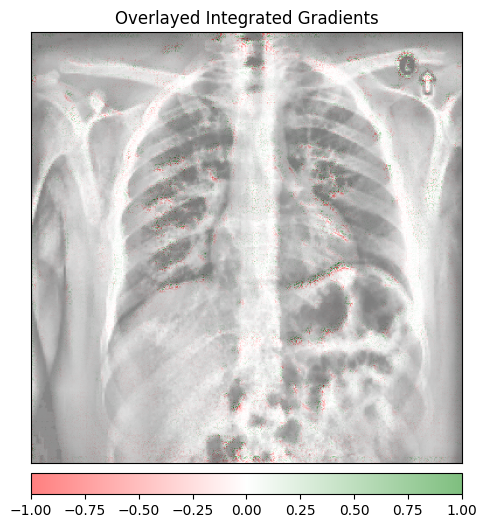

In [94]:
print('Original Image')
print('Predicted:', predicted[ind], ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = images[ind].cpu().numpy().transpose(1, 2, 0)

# blended heat map because cmap is otherwise not working
_ = viz.visualize_image_attr(original_image, original_image, method="blended_heat_map", title="Original Image", cmap="gray")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          title="Overlayed Saliency Map", show_colorbar=True)

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")
